In [42]:
import pandas as pd
import matplotlib.pyplot as plt
# In AAPL.ipynb
from stock_data import StockData
# Make plots a bit nicer
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)
from dateutil import parser

from pandas.tseries.offsets import BDay

import seaborn as sns



## Load or download a data (NVDA)

In [43]:
# ============================================
# Download META daily data for a year
# ============================================

ticker = "NVDA"
stock = StockData(ticker, start_date="2009-02-14", end_date="2020-06-03")

df = stock.load_data()
df.head()



C:\Users\Birhanu Matebe\Downloads\KAIM\Finanicial-Data-Analysis\Financial-Data-Analysis\src\stock_data.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.df = yf.download(


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2009-02-17,0.179480,0.187732,0.178793,0.183377,779576000
2009-02-18,0.184294,0.190254,0.179251,0.179480,646252000
2009-02-19,0.170082,0.189566,0.170082,0.187961,743988000
2009-02-20,0.174437,0.177188,0.166185,0.167790,770056000
2009-02-23,0.166415,0.178334,0.165269,0.177417,679548000


In [44]:
sentiment_df = pd.read_csv("../data/daily_sentiment.csv")

In [45]:
sentiment_df.sample(10)

,headline,url,publisher,date,stock,headline_length,TextBlob_Sentiment,TextBlob_Category
460098,"The Pantry, Inc. Sees Q1 Merchandise Sales $43...",https://www.benzinga.com/news/13/12/4142700/th...,Paul Quintaro,2013-12-10 00:00:00+00:00,PTRY,57,0.000000,Neutral
640074,Mylan Scores Final Win In Patent Challenge On ...,https://www.benzinga.com/news/15/04/5418970/my...,John Seward,2015-04-17 00:00:00+00:00,MYL,61,0.400000,Positive
480173,The Perfect Japanese ETF For Tuesday's Action ...,https://www.benzinga.com/etfs/sector-etfs/14/0...,Matthew McCall,2014-02-18 00:00:00+00:00,EWJ,61,0.366667,Positive
512001,Rackspace Has Hired Morgan Stanley to Evaluate...,https://www.benzinga.com/news/14/05/4560709/ra...,Paul Quintaro,2014-05-15 00:00:00+00:00,RAX,81,0.000000,Neutral
938445,25 Stocks Moving In Tuesday's Pre-Market Session,https://www.benzinga.com/news/17/07/9816289/25...,Lisa Levin,2017-07-25 00:00:00+00:00,CAT,48,0.000000,Neutral
938661,"12 Stocks To Watch For July 26, 2017",https://www.benzinga.com/news/earnings/17/07/9...,Lisa Levin,2017-07-26 00:00:00+00:00,WFM,36,0.000000,Neutral
128205,Cuckoo For Youkou (YOKU),https://www.benzinga.com/tech/11/04/1001395/cu...,Roger Nachman,2011-04-13 00:00:00+00:00,YOKU,24,0.000000,Neutral
1248763,Tanger Factory Outlet Q3 Adj. FFO $0.58 Down F...,https://www.benzinga.com/news/earnings/19/10/1...,Benzinga Newsdesk,2019-10-30 00:00:00+00:00,SKT,110,-0.155556,Negative
899245,Investors Pour Into EM ETFs To Close Q1,https://www.benzinga.com/trading-ideas/long-id...,ETF Professor,2017-03-31 00:00:00+00:00,VWO,39,0.000000,Neutral
34000,Will More Palladium ETF (NYSE:PALL) Shares Bol...,https://www.benzinga.com/10/06/314682/will-mor...,David Bettencourt,2010-06-03 00:00:00+00:00,PALL,58,0.500000,Positive


# 1. Data profiling

In [46]:
# ============================================
# Clean the columns (handle MultiIndex case)
# ============================================

# If columns are MultiIndex (like: ('Close', 'NVDA')), flatten them
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)  # keep only first level: Open, High, etc.

print("Cleaned columns:", df.columns.tolist())

# Optional: add a Ticker column (useful if using multiple tickers later)
df["Ticker"] = ticker

# Ensure index is datetime and sorted
df.index = pd.to_datetime(df.index)
df = df.sort_index()




Cleaned columns: ['Close', 'High', 'Low', 'Open', 'Volume']


# - Summary Statistics 

In [47]:

stock.inspect_data()




📌 Dataset Shape for NVDA: (2843, 6)

📌 First 5 rows:


Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2009-02-17,0.179480,0.187732,0.178793,0.183377,779576000,NVDA
2009-02-18,0.184294,0.190254,0.179251,0.179480,646252000,NVDA
2009-02-19,0.170082,0.189566,0.170082,0.187961,743988000,NVDA
2009-02-20,0.174437,0.177188,0.166185,0.167790,770056000,NVDA
2009-02-23,0.166415,0.178334,0.165269,0.177417,679548000,NVDA



📌 Last 5 rows:


Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2020-05-27,8.492886,8.599977,7.966391,8.592256,1175892000,NVDA
2020-05-28,8.454780,8.727241,8.347438,8.380313,734896000,NVDA
2020-05-29,8.841806,8.841806,8.452789,8.522025,745256000,NVDA
2020-06-01,8.772819,8.807188,8.656512,8.799716,389876000,NVDA
2020-06-02,8.791745,8.803700,8.625130,8.762856,391320000,NVDA



📌 Random 5 rows:


Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2019-05-29,3.483089,3.544639,3.448342,3.509645,559800000,NVDA
2019-09-03,4.083212,4.126489,4.060331,4.093410,296140000,NVDA
2013-01-17,0.282608,0.283761,0.279147,0.279839,580736000,NVDA
2010-02-08,0.371109,0.380049,0.363774,0.370651,445160000,NVDA
2015-06-19,0.529251,0.535300,0.524411,0.530944,355656000,NVDA



📌 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2843 entries, 2009-02-17 to 2020-06-02
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2843 non-null   float64
 1   High    2843 non-null   float64
 2   Low     2843 non-null   float64
 3   Open    2843 non-null   float64
 4   Volume  2843 non-null   int64  
 5   Ticker  2843 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 155.5+ KB


In [48]:
# check if a null value exists


key_cols = ['Close', 'Open', 'High', 'Volume', 'Ticker']

stock.check_missing_values()



📌 Missing values per column:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
Ticker    0
dtype: int64

📌 Columns with >5% missing values:
✔️ None

📌 Total rows with missing values in key columns ['Close', 'Open', 'High', 'Volume']: 0
✔️ No missing rows in key columns

📌 Duplicate rows: 0

📌 Cardinality (categoricals): {'Ticker': 1}


In [49]:
# log statistical data values
print("The description of the numeric columns:")
print(df.describe())

The description of the numeric columns:
Price        Close         High          Low         Open        Volume
count  2843.000000  2843.000000  2843.000000  2843.000000  2.843000e+03
mean      1.817840     1.846153     1.787136     1.817198  5.419409e+08
std       2.167474     2.202198     2.129567     2.166504  3.494198e+08
min       0.166415     0.177188     0.165269     0.167332  4.564400e+07
25%       0.333288     0.338560     0.328829     0.333288  3.121000e+08
50%       0.472878     0.480286     0.467622     0.475600  4.514040e+08
75%       3.626917     3.703688     3.564340     3.620602  6.771940e+08
max       8.991984     9.146896     8.855007     9.121991  3.692928e+09


In [50]:
#Overview of categorical columns
print("The description of the categorical columns:")
print(df.describe(include=['object']))

The description of the categorical columns:
Price  Ticker
count    2843
unique      1
top      NVDA
freq     2843


In [51]:
# log and check the frequency, and uniqueness of all dataset column
print("The description of all columns:")
print(df.describe(include='all'))


The description of all columns:
Price         Close         High          Low         Open        Volume  \
count   2843.000000  2843.000000  2843.000000  2843.000000  2.843000e+03   
unique          NaN          NaN          NaN          NaN           NaN   
top             NaN          NaN          NaN          NaN           NaN   
freq            NaN          NaN          NaN          NaN           NaN   
mean       1.817840     1.846153     1.787136     1.817198  5.419409e+08   
std        2.167474     2.202198     2.129567     2.166504  3.494198e+08   
min        0.166415     0.177188     0.165269     0.167332  4.564400e+07   
25%        0.333288     0.338560     0.328829     0.333288  3.121000e+08   
50%        0.472878     0.480286     0.467622     0.475600  4.514040e+08   
75%        3.626917     3.703688     3.564340     3.620602  6.771940e+08   
max        8.991984     9.146896     8.855007     9.121991  3.692928e+09   

Price  Ticker  
count    2843  
unique      1  
top    

In [52]:
#check if duplication of rows exist
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

Duplicate rows: 0


In [53]:
# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)

Cardinality (categoricals): {'Ticker': 1}


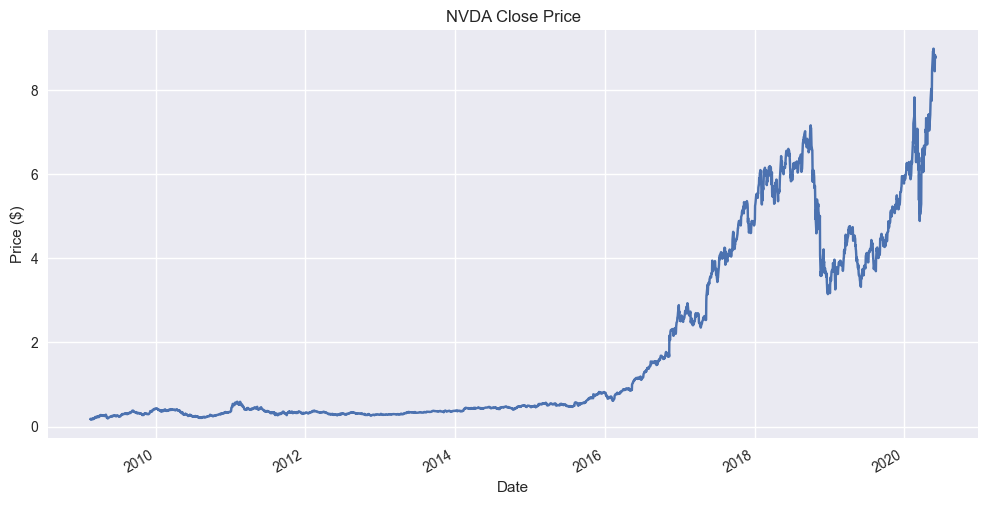

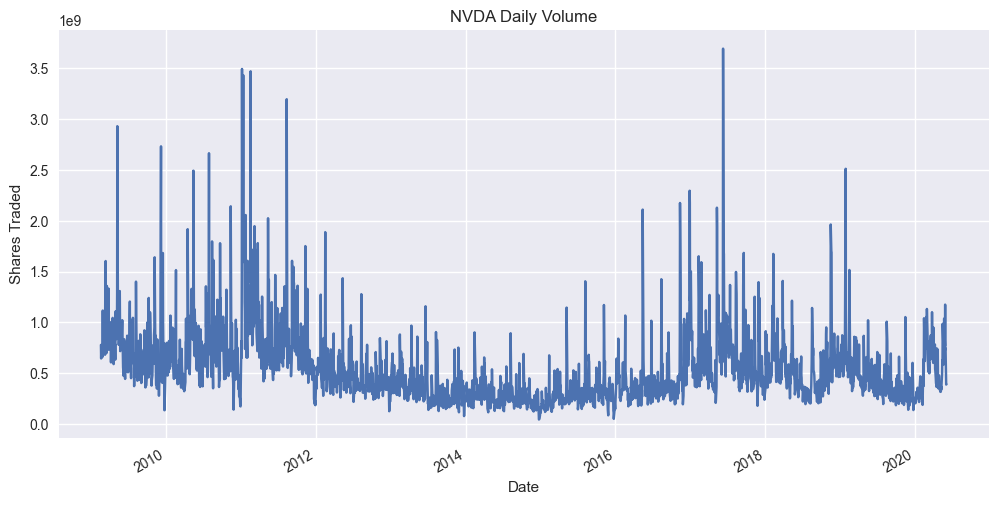

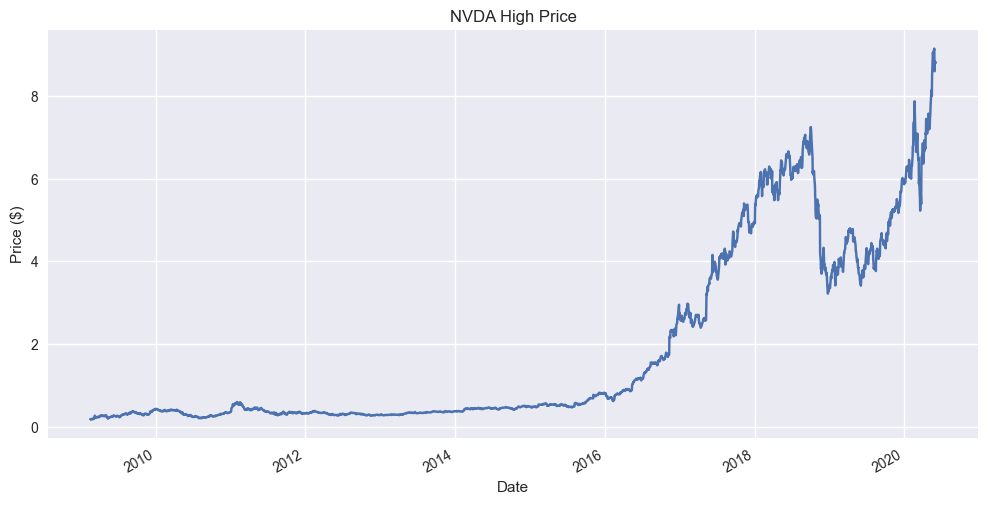

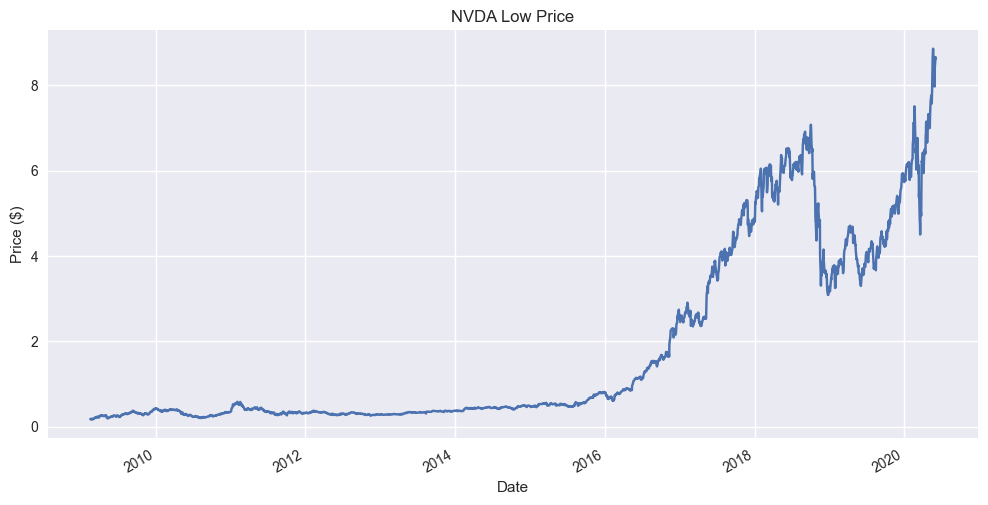

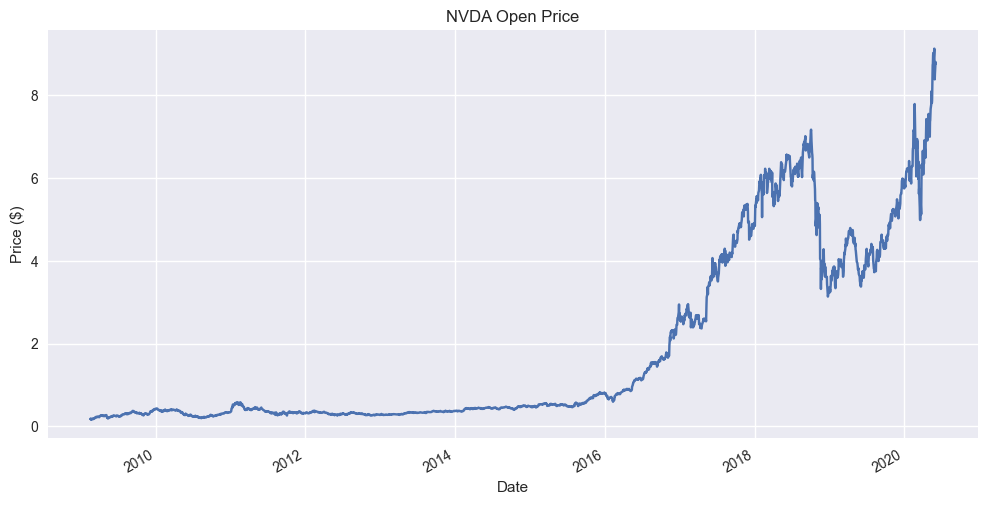

In [54]:


stock.plot_price()


## Stock price over time

## NVDA Close Price Chart Analysis
- Early Stagnation (2010–2016): The price remained relatively flat and low for several years, trading mostly between $0.20 and $0.70. This period showed low growth and high volatility for a low-priced stock.

- Massive Inflection Point (2016): Around 2016, the stock price hit a major inflection point and began a near-vertical, aggressive surge. This marks the shift as the company's chips became central to AI and data centers.

- Hyper-Growth (2016–2018): The price skyrocketed from under $1 to over $7, demonstrating an extreme rate of appreciation.

- Major Correction and Recovery (2018–2020): Similar to other tech stocks, NVDA suffered a significant correction in late 2018, dropping from the $7 range to $3. It then mounted a strong recovery, surging past its previous high to end the chart near $8.

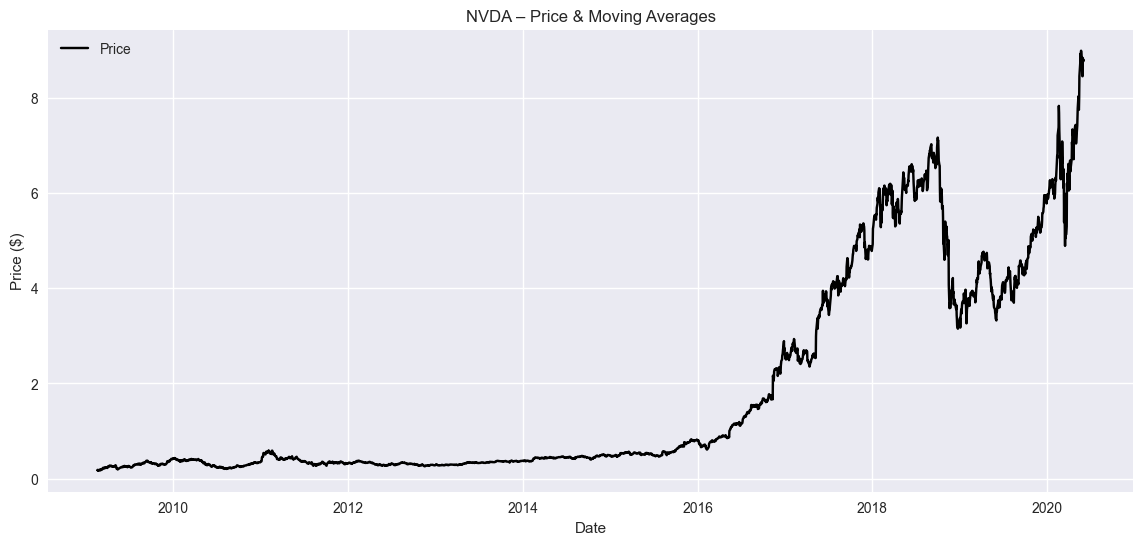

In [55]:

stock.plot_price_sma()


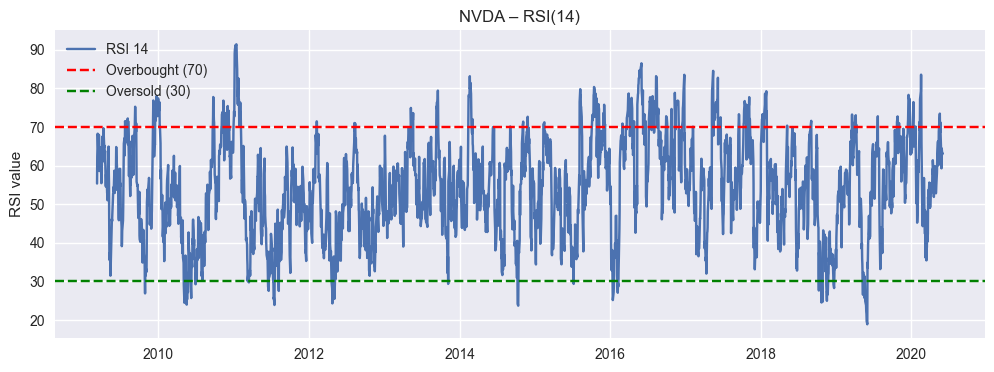

In [56]:



stock.plot_rsi()




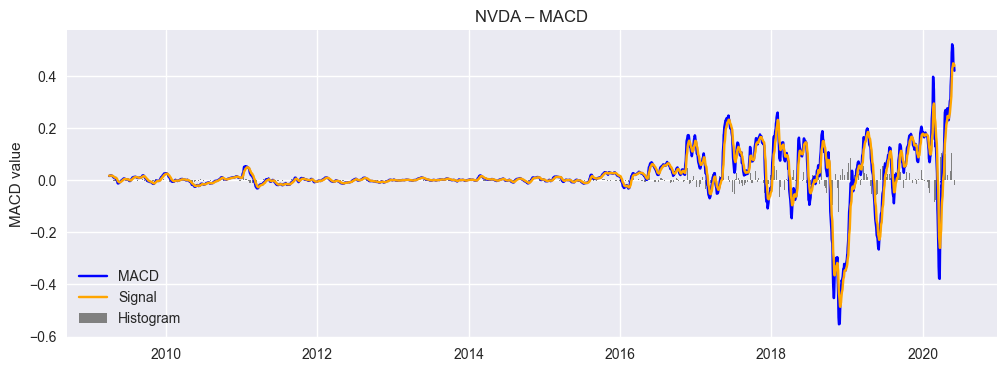

In [57]:
stock.plot_macd()


## NVDA - Price, Moving Averages Chart Analysis
The chart shows:

- 2010–2016 (Stagnation): The MAs would have been flat and tightly woven together, running directly alongside the price line (between $0.20 and $0.70). This would technically confirm the long period of a non-trending, consolidating market.

- Post-2016 (Hyper-Growth): The MAs would have experienced a dramatic shift, becoming steeply angled upward and significantly separated from each other.

- The Shorter-Term MA would be consistently and far above the Longer-Term MA. This is the clearest technical signal of an extremely powerful and healthy bull market.

- The price line, during its rallies, would often run far above both MAs, indicating an overextended condition fueled by high momentum.

- The 2018 Correction: During the sharp price drop, the price would have likely broken below the shorter-term MAs and potentially briefly touched or broken the longer-term MAs (which would have acted as strong support), confirming the correction but not a full trend reversal.

## NVDA - Relative Strength Index (RSI 14) Analysis
- Initial Fluctuation (2010–2016): The RSI spent this period swinging widely between the Overbought (70) and Oversold (30) lines while the price was flat. This is common for a low-priced stock that is consolidating and lacking a clear trend.

- Post-2016 Bullish Momentum: After 2016, the momentum profile shifts, with the RSI spending more time above the 50 centerline, consistently confirming the strong bullish trend.

- Extreme Overbought Signals: The indicator frequently spikes and stays well above the 70 line (Overbought) during the hyper-growth phase (2016–2018). This validates the intense buying pressure and high-momentum driving the stock's price acceleration.

- The 2018 Sell-off: The RSI registers a sharp, significant dip below the 30 line (Oversold) in late 2018, confirming that the severe price correction was driven by extreme panic-selling, a technical signal of a major, but temporary, momentum collapse.

## NVDA - MACD Analysis

- Initial Stagnation (2010–2016): The MACD Line (Blue) and Signal Line (Orange) remained extremely flat and tightly clustered around the zero line. This confirms the non-trending, low-momentum state of the stock price during this period.

- Post-2016 Inflection: The chart shows a sudden and dramatic shift after 2016, with the MACD beginning to oscillate with much greater amplitude.

- Extreme Volatility: The MACD is characterized by large, sharp swings (oscillations) that quickly move from strong positive readings to sharp negative readings. This confirms the high technical volatility of the stock during its hyper-growth phase.

- The 2018 Sell-off Confirmation: The deepest negative spike on the chart occurs in late 2018, dropping to approximately $\mathbf{-0.6}$. This extreme reading strongly confirmed the severe panic-selling momentum that drove the stock's major price correction.

- Strong Buy Momentum: Conversely, the sharp, large positive spikes (e.g., in late 2019/early 2020) show intense buying momentum, validating the powerful recoveries the stock experienced.

In [58]:

def safe_parse_with_utc(date_val):
    try:
        dt = parser.parse(str(date_val), dayfirst=False)  # adjust dayfirst if your dataset is DD-MM-YYYY
        return pd.Timestamp(dt, tz='UTC')
    except:
        return pd.NaT

if 'date' in df.columns:
    df['date'] = df['date'].astype(str).str.strip()
    df['date'] = df['date'].apply(safe_parse_with_utc)
    
    if df['date'].isnull().any():
        print("Warning: Some dates could not be parsed and are set as NaT.")
    
    df = df.sort_values('date').reset_index(drop=True)
    
    print(df['date'].head())
    print(f"Data type: {df['date'].dtype}")


In [59]:
df.head()

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2009-02-17,0.179480,0.187732,0.178793,0.183377,779576000,NVDA
2009-02-18,0.184294,0.190254,0.179251,0.179480,646252000,NVDA
2009-02-19,0.170082,0.189566,0.170082,0.187961,743988000,NVDA
2009-02-20,0.174437,0.177188,0.166185,0.167790,770056000,NVDA
2009-02-23,0.166415,0.178334,0.165269,0.177417,679548000,NVDA


In [60]:
print(sentiment_df.columns.tolist())


['headline', 'url', 'publisher', 'date', 'stock', 'headline_length', 'TextBlob_Sentiment', 'TextBlob_Category']


In [61]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.strftime('%Y-%m-%d')


In [62]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])


In [63]:
sentiment_df.head()


,headline,url,publisher,date,stock,headline_length,TextBlob_Sentiment,TextBlob_Category
0,How Treasuries and ETFs Work,https://www.benzinga.com/28044/how-treasuries-...,Paco Ahlgren,2009-02-14,NAV,28,0.0,Neutral
1,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,Charles Lewis Sizemore CFA,2009-04-27,Y,45,0.0,Neutral
2,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,Charles Lewis Sizemore CFA,2009-04-27,FT,45,0.0,Neutral
3,Going Against the Herd,https://www.benzinga.com/charles-lewis-sizemor...,Charles Lewis Sizemore CFA,2009-04-29,A,22,0.0,Neutral
4,Charles Sizemore Radio Interview Saturday Morning,https://www.benzinga.com/11218/charles-sizemor...,Charles Lewis Sizemore CFA,2009-05-22,AM,49,0.0,Neutral


In [64]:
sentiment_df[sentiment_df['stock'] == 'NVDA']


,headline,url,publisher,date,stock,headline_length,TextBlob_Sentiment,TextBlob_Category
116306,Nvidia Goes Negative (NVDA),https://www.benzinga.com/market-update/11/03/9...,Scott Rubin,2011-03-03,NVDA,27,-0.300000,Negative
116959,Auriga Still Not Sure Where Reality Lies For N...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffB,2011-03-07,NVDA,51,-0.250000,Negative
116967,Goldman Sachs Gives Color On Semiconductors (N...,https://www.benzinga.com/analyst-ratings/analy...,Benzinga Staff,2011-03-07,NVDA,60,0.000000,Neutral
117302,"JPM Says ""Our Bearish View on the Company's Ex...",https://www.benzinga.com/analyst-ratings/analy...,Benzinga Staff,2011-03-08,NVDA,74,-0.500000,Negative
117457,"JP Morgan Upgrades NVIDIA To Neutral, $21 PT",https://www.benzinga.com/analyst-ratings/upgra...,Joe Young,2011-03-08,NVDA,44,0.000000,Neutral
...,...,...,...,...,...,...,...,...
1349841,3 Non-Semiconductor ETFs Benefiting From Nvidi...,https://www.benzinga.com/trading-ideas/long-id...,ETF Professor,2020-05-26,NVDA,56,0.000000,Neutral
1349842,Stocks That Hit 52-Week Highs On Tuesday,https://www.benzinga.com/news/20/05/16106805/s...,Benzinga Insights,2020-05-26,NVDA,40,0.000000,Neutral
1350292,Chip Stocks Move Higher Following Strong Guida...,https://www.benzinga.com/news/20/05/16120537/c...,Benzinga Newsdesk,2020-05-27,NVDA,136,0.074444,Positive
1350293,Shares of several companies in the broader tec...,https://www.benzinga.com/wiim/20/05/16116988/s...,Benzinga Newsdesk,2020-05-27,NVDA,320,0.000000,Neutral



Pearson Correlation:
                     return  daily_sentiment  lagged_sentiment
return            1.000000         0.099463         -0.020189
daily_sentiment   0.099463         1.000000         -0.038450
lagged_sentiment -0.020189        -0.038450          1.000000

Spearman Correlation:
                     return  daily_sentiment  lagged_sentiment
return            1.000000         0.141776         -0.027700
daily_sentiment   0.141776         1.000000         -0.028979
lagged_sentiment -0.027700        -0.028979          1.000000

Kendall Correlation:
                     return  daily_sentiment  lagged_sentiment
return            1.000000         0.099144         -0.018943
daily_sentiment   0.099144         1.000000         -0.021548
lagged_sentiment -0.018943        -0.021548          1.000000


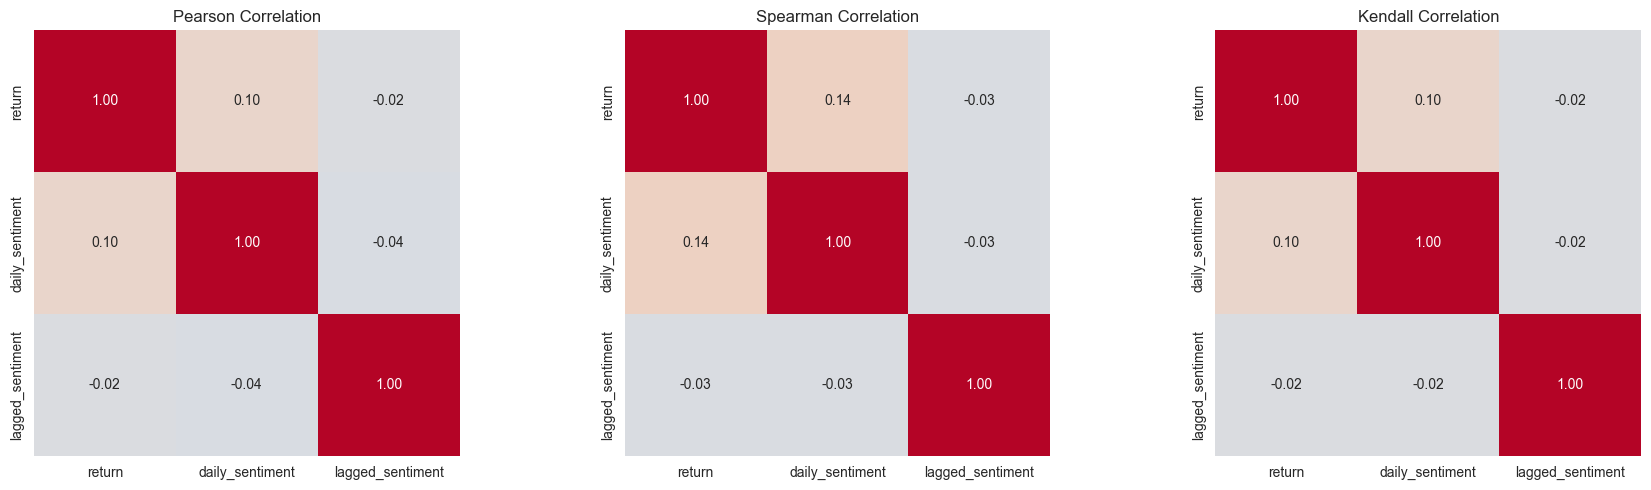

In [65]:


# -------------------------------
# 1. FILTER NEWS FOR NVDA ONLY
# -------------------------------
sentiment_df = sentiment_df[sentiment_df['stock'] == "NVDA"].copy()
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# -------------------------------
# 2. PREPARE STOCK DATA
# -------------------------------
# Ensure stock dataframe index is datetime
df.index = pd.to_datetime(df.index)

# -------------------------------
# 3. ALIGN NEWS DATES TO NEXT TRADING DAY
# -------------------------------
stock_dates = df.index

def align_to_next_trading_day(news_date):
    future_dates = stock_dates[stock_dates >= news_date]
    if len(future_dates) == 0:
        return None
    return future_dates[0]

sentiment_df['aligned_date'] = sentiment_df['date'].apply(align_to_next_trading_day)
sentiment_df = sentiment_df.dropna(subset=['aligned_date'])

# -------------------------------
# 4. AGGREGATE DAILY SENTIMENT
# -------------------------------
daily_sentiment = (
    sentiment_df.groupby('aligned_date')['TextBlob_Sentiment']
    .mean()
    .to_frame('daily_sentiment')
)

# Create lagged sentiment (previous day's sentiment)
daily_sentiment['lagged_sentiment'] = daily_sentiment['daily_sentiment'].shift(1)

# -------------------------------
# 5. CALCULATE DAILY STOCK RETURNS
# -------------------------------
df['return'] = df['Close'].pct_change()

# -------------------------------
# 6. MERGE STOCK + SENTIMENT
# -------------------------------
merged_df = df.merge(
    daily_sentiment,
    left_index=True,
    right_index=True,
    how='left'
)

# -------------------------------
# 7. CORRELATION ANALYSIS
# -------------------------------
# Drop NaNs for correlation calculation
df_corr = merged_df[['return', 'daily_sentiment', 'lagged_sentiment']].dropna()

corr_methods = {
    "Pearson": df_corr.corr(method="pearson"),
    "Spearman": df_corr.corr(method="spearman"),
    "Kendall": df_corr.corr(method="kendall"),
}

# Print correlations
for name, corr in corr_methods.items():
    print(f"\n{name} Correlation:\n", corr)

# -------------------------------
# 8. VISUALIZATION
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (title, corr) in zip(axes, corr_methods.items()):
    sns.heatmap(
        corr,
        ax=ax,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        annot=True,
        fmt=".2f",
        square=True,
        cbar=False
    )
    ax.set_title(f"{title} Correlation")

fig.tight_layout()
plt.show()


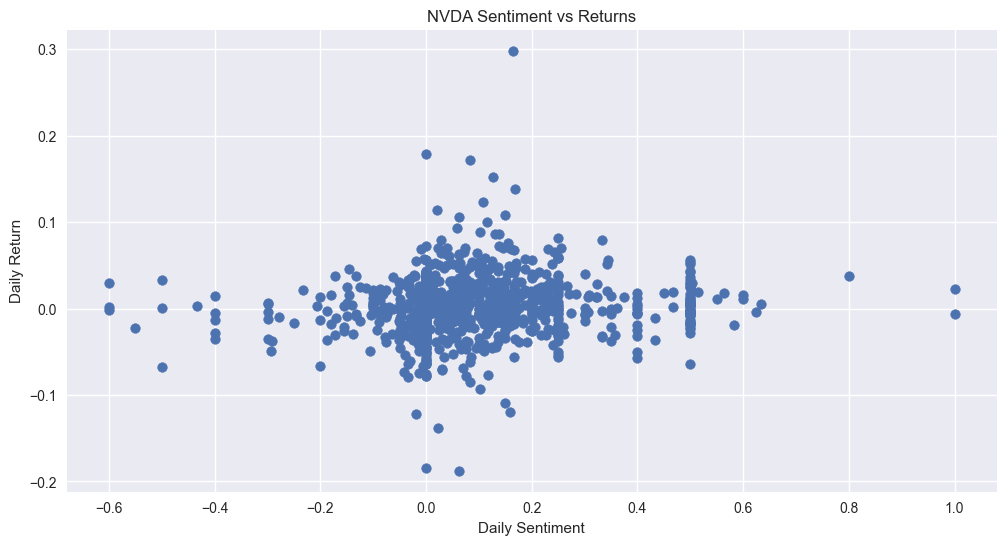

In [66]:


plt.scatter(merged_df['daily_sentiment'], merged_df['return'])
plt.xlabel("Daily Sentiment")
plt.ylabel("Daily Return")
plt.title("NVDA Sentiment vs Returns")
plt.show()


## Interpretation of NVDA Correlation
The overall finding is that the correlation coefficients are very low, suggesting that sentiment is not a primary driver or predictor of NVDA's stock returns.

1. Return vs. Sentiment Relationships
return vs. daily_sentiment (Pearson: 0.10): This is a very weak positive correlation. It means that positive stock returns tend to coincide with slightly more positive sentiment on the same day. This is generally interpreted as sentiment reacting to the stock movement rather than predicting it.

return vs. lagged_sentiment (Pearson: -0.02): The correlation is effectively zero. This indicates that the sentiment from the previous day has no measurable linear relationship with today's stock return. There is no predictive power from yesterday's news in this dataset.

2. Sentiment Persistence
daily_sentiment vs. lagged_sentiment (Pearson: -0.04): This correlation is also essentially zero. The sentiment expressed in the news about NVDA on one day is independent of the sentiment expressed the day before.

## Interpretation of the NVDA Scatter Plot
1. Zero Predictive Power ConfirmedThe data points form a large, dense, and random cloud centered almost perfectly at the origin (0.0, 0.0) .
- There is no recognizable trend, slope, or pattern in the distribution of the points. This graphically confirms that the correlation between same-day sentiment and same-day stock returns is effectively zero (as seen in the $\approx 0.10$ correlation from the matrices).
- This strong visual independence means that the sentiment score provides no useful information for predicting the magnitude or direction of NVDA's return on that specific day.

2. Centralized MovementMost activity, for both sentiment and returns, is concentrated in a tight central area:

- Returns: Most daily returns are very small, clustered between approximately -0.05 and +0.05 (i.e., $\pm 5\%$).

- Sentiment: Most sentiment scores are concentrated between -0.20 and +0.30.

3. Outlier IndependenceThe few extreme outliers further emphasize that one variable doesn't depend on the other:

- Extreme Returns (Top): The largest positive return (near +0.30) is associated with a positive sentiment (around +0.20). While they coincide, this is generally interpreted as sentiment reacting to the massive price move, rather than causing it.

- Extreme Sentiment (Far Right/Left): There are several days with highly extreme sentiment (e.g., near $+1.0$ or $-0.60$) that are associated with near-zero daily returns (Y-axis close to 0.0). This is the clearest proof that extreme news sentiment does not guarantee a corresponding price reaction on the same day.